In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.utils.extmath import softmax

In [13]:
train = pd.read_csv('train.csv')
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


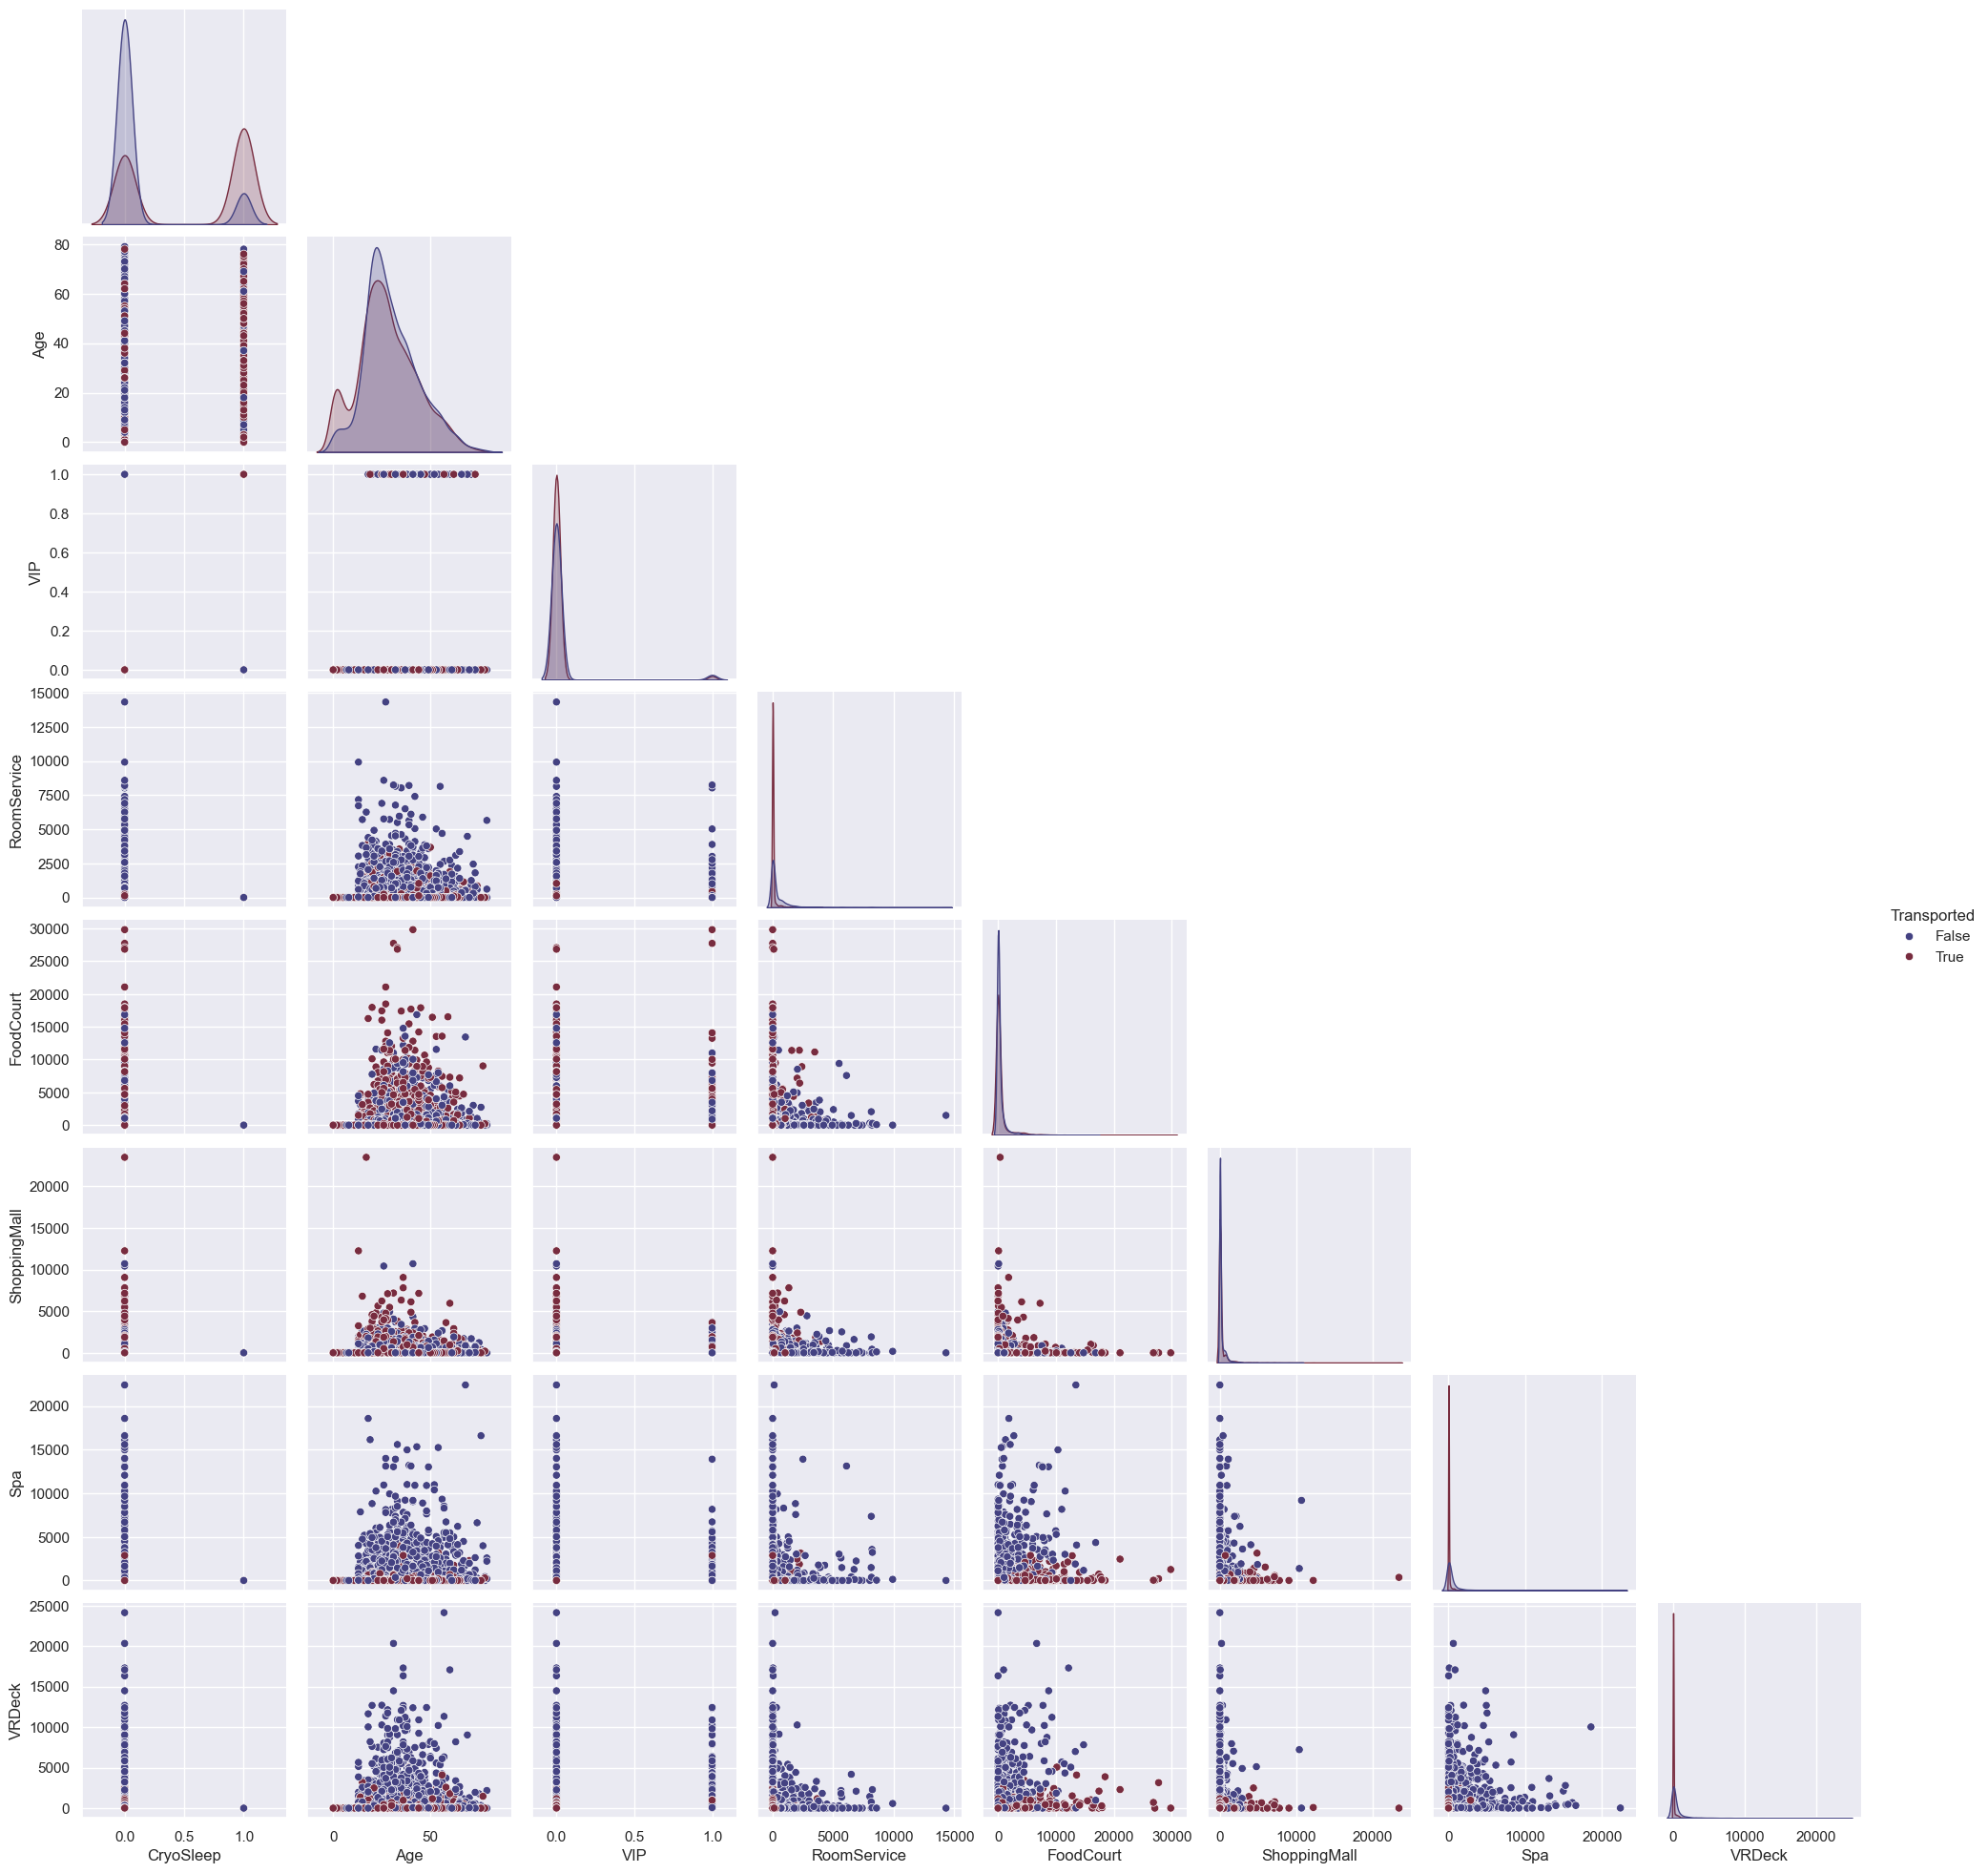

In [9]:
sns.pairplot(data = train, dropna = True, hue='Transported', palette='icefire', corner=True)

In [14]:
# Проверяем наличие PassengerId перед удалением
if 'PassengerId' in train.columns:
    train = train.drop('PassengerId', axis = 1)

# Создаем атрибут общей суммы трат на путешествие
train['TotalSum'] = train[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

# Извлекаем информацию из имен для групповых признаков
if 'Name' in train.columns:
    train['LastName'] = train['Name'].str.split().str[-1]
    train['GroupSize'] = train.groupby('LastName')['LastName'].transform('count')
    train['IsAlone'] = (train['GroupSize'] <= 1).astype(int)
else:
    train['LastName'] = 'Unknown'
    train['GroupSize'] = 1
    train['IsAlone'] = 1

try:
    train[['Deck', 'Num', 'Side']] = train['Cabin'].str.split('/', expand=True)
except:
    print("Exists or already done 1 ")
try:
    train = train.drop('Cabin', axis=1)
except:
    print("Exists or already done 2 ")

# Заполнение пропусков в Deck, Num, Side
train['Deck'] = train['Deck'].fillna('G')
train['Num'] = train['Num'].fillna('0')
train['Side'] = train['Side'].fillna('S')

deck_mode = train['Deck'].mode()[0]
num_mode = train['Num'].mode()[0]
side_mode = train['Side'].mode()[0]

print(f"Самая частая палуба: {deck_mode}")
print(f"Самый частый номер: {num_mode}")
print(f"Самая частая сторона: {side_mode}")

# 1. Деление возрастов на числовые категории
train['Age'] = train['Age'].fillna(train['Age'].median())
train['AgeGroup'] = pd.cut(train['Age'], bins=[-1,12,17,25,40,60,np.inf], labels=[0,1,2,3,4,5])
train['AgeGroup'] = train['AgeGroup'].astype(int)

# 2. Тратил ли вообще человек
train['HasSpent'] = (train['TotalSum'] > 0).astype(int)
train['HighSpender'] = (train['TotalSum'] > train['TotalSum'].quantile(0.75)).astype(int)

# Категории трат
train['Entertainment'] = train['Spa'] + train['VRDeck']
train['Food'] = train['RoomService'] + train['FoodCourt'] 
train['HasEntertainment'] = (train['Entertainment'] > 0).astype(int)
train['HasFood'] = (train['Food'] > 0).astype(int)

# 3. Возрастные категории 
train['IsChild'] = (train['Age'] < 13).astype(int)
train['IsTeenager'] = ((train['Age'] >= 13) & (train['Age'] < 18)).astype(int)
train['IsYoungAdult'] = ((train['Age'] >= 18) & (train['Age'] < 25)).astype(int)
train['IsElderly'] = (train['Age'] > 60).astype(int)

# Заполнение пропусков перед созданием новых признаков
train['CryoSleep'] = train['CryoSleep'].fillna(0).astype(int)
train['VIP'] = train['VIP'].fillna(0).astype(int)

# 4. Важные карелирующие решения
train['CryoButSpent'] = ((train['CryoSleep'] == 1) & (train['HasSpent'] == 1)).astype(int)
train['VipButNoSpend'] = ((train['VIP'] == 1) & (train['HasSpent'] == 0)).astype(int)

# 5. Семейные признаки
train['IsLargeGroup'] = (train['GroupSize'] > 4).astype(int)
train['IsMediumGroup'] = ((train['GroupSize'] > 1) & (train['GroupSize'] <= 4)).astype(int)

# 6. Полиномиальные признаки
train['Age_x_TotalSum'] = train['Age'] * train['TotalSum']
train['VIP_x_TotalSum'] = train['VIP'] * train['TotalSum']
train['CryoSleep_x_Age'] = train['CryoSleep'] * train['Age']
train['Food_x_Entertainment'] = train['Food'] * train['Entertainment']

# Кодирование категориальных признаков
cat_cols = ['HomePlanet','Destination','Deck','Side']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str).fillna('Unknown'))
    label_encoders[col] = le

# Комплексные взаимодействия
train['Age_VIP_interaction'] = train['Age'] * train['VIP'] * train['TotalSum']
train['CryoSleep_Destination'] = train['CryoSleep'] * train['Destination']

# Статистические фичи по группам
train['GroupSpendingStd'] = train.groupby('LastName')['TotalSum'].transform('std').fillna(0)

# Бинарные комбинации
train['VIP_and_HighSpender'] = ((train['VIP'] == 1) & (train['HighSpender'] == 1)).astype(int)
train['Child_in_CryoSleep'] = ((train['IsChild'] == 1) & (train['CryoSleep'] == 1)).astype(int)

# Заполнение пропусков в числовых колонках
numeric_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSum']
for col in numeric_columns:
    train[col] = train[col].fillna(train[col].median())

# Преобразование типов
train['Transported'] = train['Transported'].astype(int)

# Очистка
train = train.drop(columns=['Name', 'LastName', 'Num'], errors='ignore')

# Конвертируем все в числовые типы
for col in train.columns:
    if train[col].dtype == 'object':
        train[col] = pd.to_numeric(train[col], errors='coerce')
        train[col] = train[col].fillna(0).astype(int)

print("Проверяем NaN после обработки:")
nan_count = train.isnull().sum().sum()
print(f"Общее количество NaN: {nan_count}")

# Заполняем все оставшиеся NaN нулями
train = train.fillna(0)

print("Форма данных:", train.shape)
print("Проверяем типы данных:")
print(train.dtypes.unique())

Самая частая палуба: F
Самый частый номер: 0
Самая частая сторона: S
Проверяем NaN после обработки:
Общее количество NaN: 1644
Форма данных: (8693, 40)
Проверяем типы данных:
[dtype('int64') dtype('float64')]


In [15]:
test = pd.read_csv('test.csv')
passenger_ids = test['PassengerId'].copy()

test = test.drop('PassengerId', axis = 1)
test['TotalSum'] = test[['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

if 'Name' in test.columns:
    test['LastName'] = test['Name'].str.split().str[-1]
    test['GroupSize'] = test.groupby('LastName')['LastName'].transform('count')
    test['IsAlone'] = (test['GroupSize'] <= 1).astype(int)
else:
    test['LastName'] = 'Unknown'
    test['GroupSize'] = 1
    test['IsAlone'] = 1

if 'Cabin' in test.columns:
    test[['Deck', 'Num', 'Side']] = test['Cabin'].str.split('/', expand=True)
    test = test.drop('Cabin', axis=1)

test['Deck'] = test['Deck'].fillna(deck_mode)
test['Num'] = test['Num'].fillna(num_mode)
test['Side'] = test['Side'].fillna(side_mode)

test['Age'] = test['Age'].fillna(test['Age'].median())
test['AgeGroup'] = pd.cut(test['Age'], bins=[-1,12,17,25,40,60,np.inf], labels=[0,1,2,3,4,5])
test['AgeGroup'] = test['AgeGroup'].astype(int)

test['HasSpent'] = (test['TotalSum'] > 0).astype(int)
test['HighSpender'] = (test['TotalSum'] > test['TotalSum'].quantile(0.75)).astype(int)

test['Entertainment'] = test['Spa'] + test['VRDeck']
test['Food'] = test['RoomService'] + test['FoodCourt'] 
test['HasEntertainment'] = (test['Entertainment'] > 0).astype(int)
test['HasFood'] = (test['Food'] > 0).astype(int)

test['IsChild'] = (test['Age'] < 13).astype(int)
test['IsTeenager'] = ((test['Age'] >= 13) & (test['Age'] < 18)).astype(int)
test['IsYoungAdult'] = ((test['Age'] >= 18) & (test['Age'] < 25)).astype(int)
test['IsElderly'] = (test['Age'] > 60).astype(int)

test['CryoSleep'] = test['CryoSleep'].fillna(0).astype(int)
test['VIP'] = test['VIP'].fillna(0).astype(int)

test['CryoButSpent'] = ((test['CryoSleep'] == 1) & (test['HasSpent'] == 1)).astype(int)
test['VipButNoSpend'] = ((test['VIP'] == 1) & (test['HasSpent'] == 0)).astype(int)

test['IsLargeGroup'] = (test['GroupSize'] > 4).astype(int)
test['IsMediumGroup'] = ((test['GroupSize'] > 1) & (test['GroupSize'] <= 4)).astype(int)

test['Age_x_TotalSum'] = test['Age'] * test['TotalSum']
test['VIP_x_TotalSum'] = test['VIP'] * test['TotalSum']
test['CryoSleep_x_Age'] = test['CryoSleep'] * test['Age']
test['Food_x_Entertainment'] = test['Food'] * test['Entertainment']

for col in cat_cols:
    if col in label_encoders:
        test[col] = test[col].astype(str).fillna('Unknown')
        test[col] = test[col].map(lambda x: x if x in label_encoders[col].classes_ else 'Unknown')
        test[col] = label_encoders[col].transform(test[col])

test['Age_VIP_interaction'] = test['Age'] * test['VIP'] * test['TotalSum']
test['CryoSleep_Destination'] = test['CryoSleep'] * test['Destination']

test['GroupSpendingStd'] = test.groupby('LastName')['TotalSum'].transform('std').fillna(0)

test['VIP_and_HighSpender'] = ((test['VIP'] == 1) & (test['HighSpender'] == 1)).astype(int)
test['Child_in_CryoSleep'] = ((test['IsChild'] == 1) & (test['CryoSleep'] == 1)).astype(int)

for col in numeric_columns:
    test[col] = test[col].fillna(test[col].median())

test = test.drop(columns=['Name', 'LastName', 'Num'], errors='ignore')

for col in test.columns:
    if test[col].dtype == 'object':
        test[col] = pd.to_numeric(test[col], errors='coerce')
        test[col] = test[col].fillna(0).astype(int)

In [29]:
def feature_importances(df):
    X = df.drop('Transported', axis=1)
    y = df['Transported']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    # Logistic Regression
    clf_lr = lr_pipeline()
    clf_lr.fit(X_train, y_train)
    coef_lr = np.abs(clf_lr.named_steps['lr'].coef_[0])  

    acc_train_lr = accuracy_score(y_true=y_train, y_pred=clf_lr.predict(X_train))
    acc_test_lr = accuracy_score(y_true=y_test, y_pred=clf_lr.predict(X_test))

    # Random Forest
    clf_rf = rf_pipeline()
    clf_rf.fit(X_train, y_train)
    coef_rf = clf_rf.named_steps['rf'].feature_importances_  
    
    acc_train_rf = accuracy_score(y_true=y_train, y_pred=clf_rf.predict(X_train))
    acc_test_rf = accuracy_score(y_true=y_test, y_pred=clf_rf.predict(X_test))

    # Создание DataFrame с важностью признаков
    feature_importances_df = pd.DataFrame({
        'Feature': X.columns,
        'LR': coef_lr,
        'RF': coef_rf
    })

    # Топ-20 признаков
    feature_importances_df = feature_importances_df.sort_values(by='RF', ascending=False).head(30)

    # Нормализация для сравнения
    sc = MaxAbsScaler()
    feature_importances_df[['LR']] = sc.fit_transform(feature_importances_df[['LR']])
    feature_importances_df[['RF']] = sc.fit_transform(feature_importances_df[['RF']])

    # Построение графика
    plt.figure(figsize=(30, 20))
    feature_importances_df.set_index('Feature')[['LR', 'RF']].plot(kind='barh')
    plt.title('Топ-20 важных признаков')
    plt.legend(['Logistic Regression', 'Random Forest'])
    plt.tight_layout()
    plt.show()

    print(f"LR - Train: {acc_train_lr:.3f}, Test: {acc_test_lr:.3f}")
    print(f"RF - Train: {acc_train_rf:.3f}, Test: {acc_test_rf:.3f}")

    return ([acc_train_lr, acc_train_rf], [acc_test_lr, acc_test_rf])

In [30]:
# Определяем функции пайплайнов
from sklearn.pipeline import Pipeline

def lr_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(random_state=0, max_iter=1000))
    ])

def rf_pipeline():
    return Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(random_state=0, n_estimators=100))
    ])

In [31]:
train.isnull().sum()

HomePlanet               0
CryoSleep                0
Destination              0
Age                      0
VIP                      0
RoomService              0
FoodCourt                0
ShoppingMall             0
Spa                      0
VRDeck                   0
Transported              0
TotalSum                 0
GroupSize                0
IsAlone                  0
Deck                     0
Side                     0
AgeGroup                 0
HasSpent                 0
HighSpender              0
Entertainment            0
Food                     0
HasEntertainment         0
HasFood                  0
IsChild                  0
IsTeenager               0
IsYoungAdult             0
IsElderly                0
CryoButSpent             0
VipButNoSpend            0
IsLargeGroup             0
IsMediumGroup            0
Age_x_TotalSum           0
VIP_x_TotalSum           0
CryoSleep_x_Age          0
Food_x_Entertainment     0
Age_VIP_interaction      0
CryoSleep_Destination    0
G

<Figure size 3000x2000 with 0 Axes>

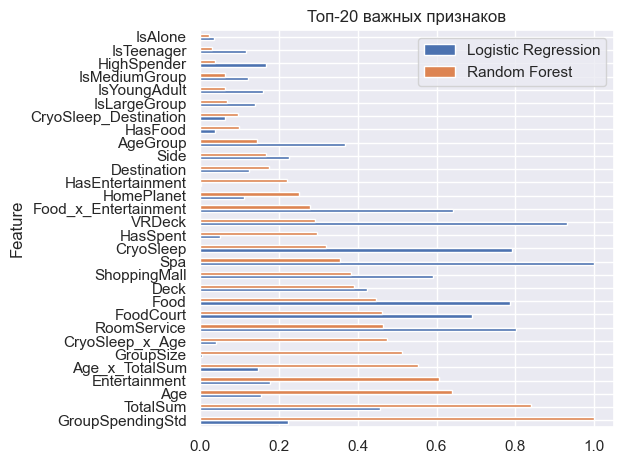

LR - Train: 0.794, Test: 0.788
RF - Train: 1.000, Test: 0.797


In [32]:
acc_train, acc_test = feature_importances(train)